In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.models import load_model
import ast
from tensorflow.keras.preprocessing import image

from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
os.chdir("../dataset")

In [3]:
parent = "2_0_ready"

train_path = f"{parent}/train"
validation_path = f"{parent}/validation"
test_path = f"{parent}/test"

In [4]:
batch_size = 32
img_height = 400
img_width = 400

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator(
                rescale=1./255,
                # zoom_range=0.15, 
                # width_shift_range=0.2,
                # shear_range=0.15
                )
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
#setting train test split
train = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        subset='training' )

test = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False )

validation = test_datagen.flow_from_directory(
        validation_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False )

Found 7600 images belonging to 2 classes.
Found 900 images belonging to 2 classes.
Found 925 images belonging to 2 classes.


In [7]:
classes = train.num_classes
classes

2

In [8]:
labels=train.class_indices
final_labels={v: k for k, v in labels.items()}

In [9]:
# conv_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) 
conv_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) 

In [10]:
def main_model(tl_model,classess):
    m_model=tl_model.output
    m_model=Flatten()(m_model)
#     m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dropout(.2)(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dropout(.2)(m_model)
    m_model=Dense(512,activation='relu')(m_model)
    m_model=Dropout(.2)(m_model)
    m_model=Dense(classess,activation='softmax')(m_model)
    return m_model

In [11]:
combining_model=main_model(conv_model, classes)
model=Model(inputs=conv_model.input, outputs=combining_model)

In [12]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [13]:
os.chdir("../program/")
model.load_weights('model_project.h5')  # load best val_accuracy
os.chdir("../dataset/")

In [19]:
def prediksi(imgname, from_test_dir):
    test_image=cv2.imread(imgname)
    test_image=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    dest_area = img_width * img_height
    source_area = test_image.shape[0] * test_image.shape[1]
    test_image = cv2.resize(test_image, (img_width, img_height), interpolation=cv2.INTER_AREA if source_area > dest_area else cv2.INTER_CUBIC)

    plt.imshow(test_image)
    plt.show()

    test_image=np.asarray(test_image)
    test_image=np.expand_dims(test_image, axis=0)
    result=model.predict(test_image)

    result_dict=dict()
    for key in list(final_labels.keys()):
        result_dict[final_labels[key]] = result[0][key]
    
    sorted_result={k: v for k, v in sorted(result_dict.items(),key=lambda item:item[1], reverse=True)}

    if not from_test_dir:
        print('='*50)
        for label in sorted_result.keys():
            print('{}:{}%'.format(label, sorted_result[label]*100))
    
    final_result=dict()
    final_result[list(sorted_result.keys())[0]]=sorted_result[list(sorted_result.keys())[0]]*100

    return final_result


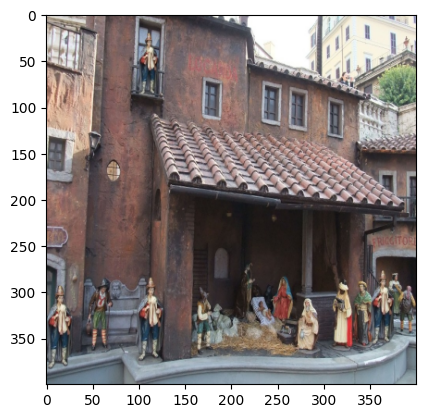

1/1 [==============================] - 0s 19ms/step
forged:100.0%
original:0.0%
Original:  {'forged': 100.0}


In [31]:
org = prediksi(os.path.join("MICC-F220", "DSC_0812_scale.jpg"), False)
print('Original: ', org)

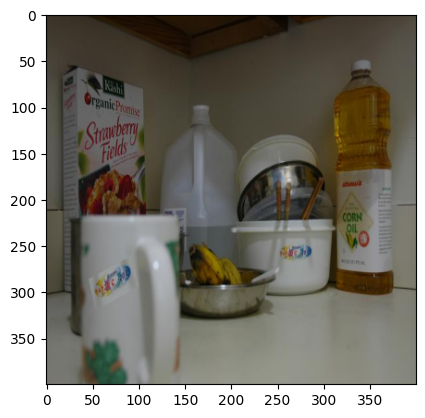

1/1 [==============================] - 0s 25ms/step
forged:100.0%
original:0.0%
Forged:  {'forged': 100.0}


In [42]:
frg = prediksi(os.path.join("MICC-F220", "DSC_1568tamp237.jpg"), False)
print('Forged: ', frg)